Rule-based final NAV: 0.9441389531230093


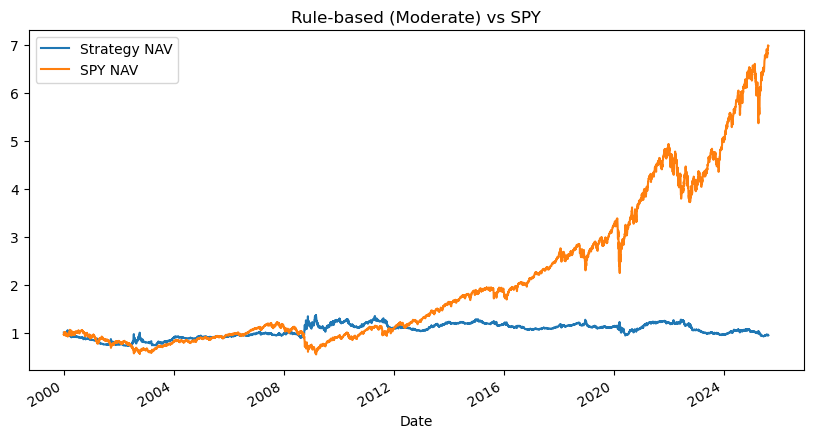

[ML] SPY test AUC = 0.504 (n=1934)
[ML] GLD test AUC = 0.514 (n=1566)
[ML] VGT test AUC = 0.530 (n=1627)
[ML] VB test AUC = 0.495 (n=1627)
[ML] IVE test AUC = 0.480 (n=1904)
[ML] XLI test AUC = 0.493 (n=1934)
[ML] XLU test AUC = 0.505 (n=1934)
[ML] SLV test AUC = 0.512 (n=1458)
[ML] USO test AUC = 0.499 (n=1461)
ML-based final NAV: 1.182950322351682


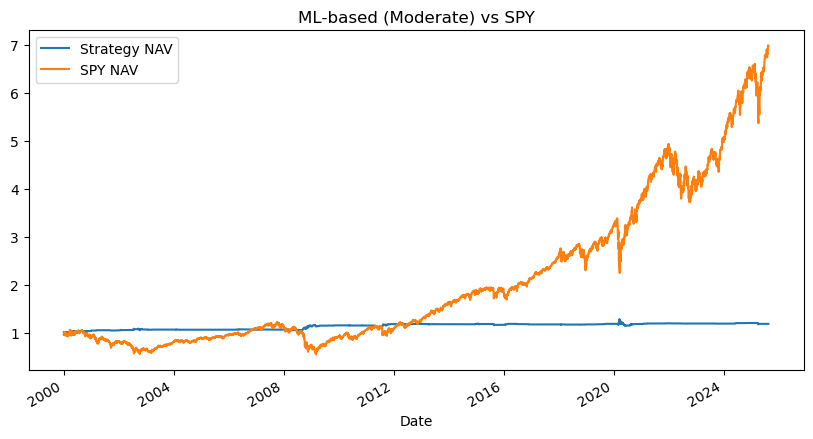

In [5]:
# ============================================
# Multi-level Prediction & Trading – Full Assignment Code
# ============================================
# Includes:
# - Data loading
# - Feature engineering
# - Rule-based strategy (EMA + momentum)
# - ML-based strategy (Logistic Regression, Jump-Start style)
# - Backtest & plotting
# - Main section to run both strategies and compare
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

# -------- CONFIG --------
DATA_DIR = "./data"
TICKERS = {
    "SPY": "spy_daily_data.csv",
    "GLD": "gld_daily_data.csv",
    "VGT": "vgt_daily_data.csv",
    "VB":  "vb_daily_data.csv",
    "IVE": "ive_daily_data.csv",
    "XLI": "xli_daily_data.csv",
    "XLU": "xlu_daily_data.csv",
    "SLV": "slv_daily_data.csv",
    "USO": "uso_daily_data.csv",
}
RISK_LEVEL = "Moderate"   # Low / Moderate / High
ALLOW_SHORT = True
INITIAL_CASH = 100_000.0
FEE = 0.0
SLIPPAGE = 0.0

EMA_FAST = 40
EMA_SLOW = 80
BENCH_TICKER = "SPY"

# -------- Data loading --------

def load_one_series(data_dir: str, ticker: str, filename: str) -> pd.DataFrame:
    path = os.path.join(data_dir, filename)
    df = pd.read_csv(path)
    col_map = {c.lower(): c for c in df.columns}
    date_col = col_map.get("date") or col_map.get("timestamp") or list(df.columns)[0]
    close_col = col_map.get("close") or list(df.columns)[1]
    df = df.rename(columns={date_col: "Date", close_col: "Close"})
    # unify mixed time zones to UTC, then drop tz to get naive timestamps
    s = pd.to_datetime(df["Date"], utc=True, errors="coerce")
    df["Date"] = s.dt.tz_convert("UTC").dt.tz_localize(None)
    df = df.sort_values("Date").dropna(subset=["Close"]).copy()
    df["Ticker"] = ticker
    return df[["Date", "Ticker", "Close"]]

def load_all(data_dir: str, tickers: dict) -> pd.DataFrame:
    frames = [load_one_series(data_dir, t, f) for t, f in tickers.items()]
    return pd.concat(frames, ignore_index=True)

# -------- Features --------
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["ret_1d"] = out.groupby("Ticker")["Close"].pct_change(1)
    out["ema_fast"] = out.groupby("Ticker")["Close"].transform(
        lambda x: x.ewm(span=EMA_FAST, adjust=False).mean()
    )
    out["ema_slow"] = out.groupby("Ticker")["Close"].transform(
        lambda x: x.ewm(span=EMA_SLOW, adjust=False).mean()
    )
    out["ema_gap"] = (out["ema_fast"] - out["ema_slow"]) / out["Close"]
    out["vol_20"] = out.groupby("Ticker")["ret_1d"].transform(
        lambda x: x.rolling(20, min_periods=5).std()
    ).fillna(0.0)
    out["next_ret"] = out.groupby("Ticker")["ret_1d"].shift(-1)
    out["label_up_tomorrow"] = (out["next_ret"] > 0).astype(int)
    return out

# -------- Rule-based strategy --------
def score_rule_based_row(row) -> float:
    base = 1500.0 * row.get("ema_gap", 0.0)
    if pd.notna(row.get("ret_1d")):
        base += 5.0 if row["ret_1d"] > 0 else -5.0
    return max(min(base, 100.0), -100.0)

def decide_action(score: float, risk: str = "Moderate") -> str:
    cutoffs = {
        "Low": {"buy": 5, "sell": -5},
        "Moderate": {"buy": 15, "sell": -15},
        "High": {"buy": 25, "sell": -25},
    }
    c = cutoffs[risk]
    if score >= c["buy"]:
        return "BUY"
    elif score <= c["sell"]:
        return "SELL"
    return "HOLD"

def position_from_action(action: str, allow_short: bool = True) -> int:
    if action == "BUY": return 1
    if action == "SELL": return -1 if allow_short else 0
    return 0

# -------- ML-based strategy (Jump-Start style) --------
def fit_ml_models(feat: pd.DataFrame, tickers: dict):
    models = {}
    feats = ["ret_1d", "ema_gap", "vol_20"]
    for t in tickers.keys():
        sub = feat[feat["Ticker"] == t].dropna(subset=feats + ["label_up_tomorrow"]).copy()
        if len(sub) < 200:
            continue
        split = int(len(sub) * 0.7)
        X_train = sub[feats].iloc[:split]
        y_train = sub["label_up_tomorrow"].iloc[:split]
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(max_iter=200))
        ])
        pipe.fit(X_train, y_train)
        models[t] = pipe
        try:
            X_test = sub[feats].iloc[split:]
            y_test = sub["label_up_tomorrow"].iloc[split:]
            proba = pipe.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, proba)
            print(f"[ML] {t} test AUC = {auc:.3f} (n={len(y_test)})")
        except:
            pass
    return models

def score_ml(feat: pd.DataFrame, models: dict) -> pd.Series:
    feats = ["ret_1d", "ema_gap", "vol_20"]
    scores = []
    for idx, row in feat.iterrows():
        m = models.get(row["Ticker"])
        if m is None or any(pd.isna(row[f]) for f in feats):
            scores.append(np.nan)
        else:
            # give sklearn a DataFrame with proper feature names
            X_one = pd.DataFrame([[row[f] for f in feats]], columns=feats)
            p = float(m.predict_proba(X_one)[0, 1])
            scores.append((p - 0.5) * 200.0)
    return pd.Series(scores, index=feat.index, name="score_ml")

# -------- Backtest --------

def backtest(feat: pd.DataFrame, score_col: str, risk: str = "Moderate"):
    df = feat.copy()
    df["action"] = df[score_col].apply(lambda s: decide_action(s, risk) if pd.notna(s) else "HOLD")
    df["pos"] = df["action"].apply(lambda a: position_from_action(a, ALLOW_SHORT))
    df["pos_shift"] = df.groupby("Ticker")["pos"].shift(0)
    df["strat_ret"] = df["pos_shift"] * df["next_ret"]

    # ✅ no DeprecationWarning, faster than groupby.apply
    df["turnover"] = (
        df.groupby("Ticker")["pos_shift"]
          .transform(lambda p: p.fillna(0).diff().abs().fillna(0))
    )

    df["strat_ret_net"] = df["strat_ret"] - df["turnover"] * (FEE + SLIPPAGE) * 0.5

    daily = df.groupby("Date").agg(
        portfolio_ret_net=("strat_ret_net", "mean"),
    ).dropna()
    daily["portfolio_nav"] = (1 + daily["portfolio_ret_net"]).cumprod()

    spy = df[df["Ticker"] == BENCH_TICKER]
    spy_daily = spy.groupby("Date")["ret_1d"].mean().dropna().to_frame("bench_ret")
    spy_daily["bench_nav"] = (1 + spy_daily["bench_ret"]).cumprod()
    res = daily.join(spy_daily, how="inner")

    return res

def plot_equity(res: pd.DataFrame, title: str):
    plt.figure(figsize=(10, 5))
    res["portfolio_nav"].plot(label="Strategy NAV")
    res["bench_nav"].plot(label=f"{BENCH_TICKER} NAV")
    plt.title(title)
    plt.legend()
    plt.show()

# -------- MAIN --------
if __name__ == "__main__":
    price = load_all(DATA_DIR, TICKERS)
    feat = add_features(price)

    # Rule-based
    feat["score_rule"] = feat.apply(score_rule_based_row, axis=1)
    res_rule = backtest(feat, "score_rule", RISK_LEVEL)
    print("Rule-based final NAV:", res_rule["portfolio_nav"].iloc[-1])
    plot_equity(res_rule, f"Rule-based ({RISK_LEVEL}) vs {BENCH_TICKER}")

    # ML-based
    models = fit_ml_models(feat, TICKERS)
    feat["score_ml"] = score_ml(feat, models)
    res_ml = backtest(feat, "score_ml", RISK_LEVEL)
    print("ML-based final NAV:", res_ml["portfolio_nav"].iloc[-1])
    plot_equity(res_ml, f"ML-based ({RISK_LEVEL}) vs {BENCH_TICKER}")
